# Vision Transformer and Masked Autoencoder

In this assignment, you will be implementing [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) and [Masked Autoencoder (MAE)](https://arxiv.org/abs/2111.06377).

## Setup

We recommend working on Colab with GPU enabled since this assignment needs a fair amount of compute.
In Colab, we can enforce using GPU by clicking `Runtime -> Change Runtime Type -> Hardware accelerator` and selecting `GPU`.
The dependencies will be installed once the notebooks are excuted.

You should make a copy of this notebook to your Google Drive otherwise the outputs will not be saved.
Once the folder is copied, you can start working by clicking a Jupyter Notebook and openning it in Colab.

In [1]:
#@title Install einops
!python -m pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00


In [6]:
#@title Import packages
import numpy as np
from matplotlib import pyplot as plt
import seaborn
seaborn.set()

from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import einops
import pickle
import os
import io
import urllib.request

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
root_folder = colab_root_folder = os.getcwd()

In [3]:
# Mount drive to save models and logs
# If you are not using colab, you can ignore this cell
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Note**: change ```root_folder``` to the folder of this notebook in your google drive

In [4]:
root_folder = "/content/drive/MyDrive/cs182_hw9_mae/"
os.makedirs(root_folder, exist_ok=True)
os.chdir(root_folder)

In [7]:
#@title Download Testing Data

def load_from_url(url):
    return torch.load(io.BytesIO(urllib.request.urlopen(url).read()))

test_data = load_from_url('https://github.com/Berkeley-CS182/cs182hw9/raw/main/test_reference.pt')
auto_grader_data = load_from_url('https://github.com/Berkeley-CS182/cs182hw9/raw/main/autograder_student.pt')
auto_grader_data['output'] = {}

In [8]:
#@title Utilities for Testing
def save_auto_grader_data():
    torch.save(
        {'output': auto_grader_data['output']},
        'autograder.pt'
    )

def rel_error(x, y):
    return torch.max(
        torch.abs(x - y)
        / (torch.maximum(torch.tensor(1e-8), torch.abs(x) + torch.abs(y)))
    ).item()

def check_error(name, x, y, tol=1e-3):
    error = rel_error(x, y)
    if error > tol:
        print(f'The relative error for {name} is {error}, should be smaller than {tol}')
    else:
        print(f'The relative error for {name} is {error}')

def check_acc(acc, threshold):
    if acc < threshold:
        print(f'The accuracy {acc} should >= threshold accuracy {threshold}')
    else:
        print(f'The accuracy {acc} is better than threshold accuracy {threshold}')

## Vision Transformer
The first part of this notebook is implementing Vision Transformer (ViT) and training it on CIFAR dataset.


### Image patchify and unpatchify

In ViT, an image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. The architecture can be seen in the following figure.
![vit](https://github.com/google-research/vision_transformer/blob/main/vit_figure.png?raw=true)

To get started with implementing ViT, we need to implement splitting image batch into fixed-size patches batch in ```patchify``` and combining patches batch into the original image batch in ```unpatchify```. The `patchify` function has been implemented for you. **Please implement `unpatchify`.**

This implementation uses [einops](https://github.com/arogozhnikov/einops) for flexible tensor operations, you can check out its [tutorial](https://einops.rocks/1-einops-basics/). 

In [9]:
def patchify(images, patch_size=4):
    """Splitting images into patches.
    Args:
        images: Input tensor with size (batch, channels, height, width)
    Returns:
        A batch of image patches with size (
          batch, (height / patch_size) * (width / patch_size), 
        channels * patch_size * patch_size)
        
    Hint: use einops.rearrange. The "space-to-depth operation" example at https://einops.rocks/api/rearrange/ 
    is not exactly what you need, but it gives a good idea of how to use rearrange.
    """
    return einops.rearrange(
        images,
        'b c (h p1) (w p2) -> b (h w) (c p1 p2)',
        p1=patch_size,
        p2=patch_size
    )

def unpatchify(patches, patch_size=4):
    """Combining patches into images.
    Args:
        patches: Input tensor with size (
        batch, (height / patch_size) * (width / patch_size), 
        channels * patch_size * patch_size)
    Returns:
        A batch of images with size (batch, channels, height, width)
        
    Hint: einops.rearrange can be used here as well.
    """
    ############################################################################
    # TODO: implement this function
    ############################################################################
    return einops.rearrange(
        patches,
        "b (h w) (c p1 p2) -> b c (h p1) (w p2)",
        p1=patch_size,
        p2=patch_size,
        h=int(patches.shape[1] ** 0.5),
        w=int(patches.shape[1] ** 0.5)
    )
    ############################################################################

In [10]:
#@title Test your implementation
x = test_data['input']['patchify']
y = test_data['output']['patchify']
check_error('patchify', patchify(x), y)

x = auto_grader_data['input']['patchify']
auto_grader_data['output']['patchify'] = patchify(x)
save_auto_grader_data()


x = test_data['input']['unpatchify']
y = test_data['output']['unpatchify']
check_error('unpatchify', unpatchify(x), y)

x = auto_grader_data['input']['unpatchify']
auto_grader_data['output']['unpatchify'] = unpatchify(x)

save_auto_grader_data()

The relative error for patchify is 0.0
The relative error for unpatchify is 0.0


### ViT Model

Here is an implementation of a Transformer. It simply wraps `nn.TransformerEncoder` of PyTorch.

In [11]:
class Transformer(nn.Module):
    """Transformer Encoder 
    Args:
        embedding_dim: dimension of embedding
        n_heads: number of attention heads
        n_layers: number of attention layers
        feedforward_dim: hidden dimension of MLP layer
    Returns:
        Transformer embedding of input
    """
    def __init__(self, embedding_dim=256, n_heads=4, n_layers=4, feedforward_dim=1024):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.feedforward_dim = feedforward_dim
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embedding_dim,
                nhead=self.n_heads,
                dim_feedforward=self.feedforward_dim,
                activation=F.gelu,
                batch_first=True,
                dropout=0.0,
            ),
            num_layers=n_layers,
        )

    def forward(self, x):
        return self.transformer(x)

**Implement the `forward` method of `ClassificationViT`**, use the layers defined in the constructor and `patchify`/`unpachify` function implemented above.

In [12]:
class ClassificationViT(nn.Module):
    """Vision transformer for classfication
    Args:
        n_classes: number of classes 
        embedding_dim: dimension of embedding
        patch_size: image patch size
        num_patches: number of image patches
    Returns:
        Logits of classfication
    """
    def __init__(self, n_classes, embedding_dim=256, patch_size=4, num_patches=8):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.embedding_dim = embedding_dim

        self.transformer = Transformer(embedding_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim) * 0.02)
        self.position_encoding = nn.Parameter(
            torch.randn(1, num_patches * num_patches + 1, embedding_dim) * 0.02
        )
        self.patch_projection = nn.Linear(patch_size * patch_size * 3, embedding_dim)
        
        # A Layernorm and a Linear layer are applied on ViT encoder embeddings
        self.output_head = nn.Sequential(
            nn.LayerNorm(embedding_dim), nn.Linear(embedding_dim, n_classes)
        )

    def forward(self, images):
        """ 
        (1) Splitting images into fixed-size patches; 
        (2) Linearly embed each image patch, prepend CLS token; 
        (3) Add position embeddings;
        (4) Feed the resulting sequence of vectors to Transformer encoder.
        (5) Extract the embeddings corresponding to the CLS token.
        (6) Apply output head to the embeddings to obtain the logits
        """
        ########################################################################
        # TODO: implement this function
        ########################################################################
        patches = patchify(images, self.patch_size)
        patch_embeddings = self.patch_projection(patches)
        cls_token = torch.broadcast_to(
            self.cls_token,
            (images.shape[0], 1, self.embedding_dim)
        )
        embeddings = torch.cat([cls_token, patch_embeddings], dim=1) + self.position_encoding
        vit_embeddings = self.transformer(embeddings)
        logits = self.output_head(vit_embeddings[:, 0, :])
        return logits
        ########################################################################

In [13]:
#@title Test your implementation
model = ClassificationViT(10)
model.load_state_dict(test_data['weights']['ClassificationViT'])
x = test_data['input']['ClassificationViT.forward']
y = model.forward(x)
check_error('ClassificationViT.forward', y, test_data['output']['ClassificationViT.forward'])

model.load_state_dict(auto_grader_data['weights']['ClassificationViT'])
x = auto_grader_data['input']['ClassificationViT.forward']
y = model.forward(x)
auto_grader_data['output']['ClassificationViT.forward'] = y
save_auto_grader_data()

The relative error for ClassificationViT.forward is 1.251074172614608e-05


### Data Loader and Preprocess

We use ```torchvision``` to download and prepare images and labels. ViT usually works on a much larger image dataset, but due to our limited computational resources, we train our ViT on CIFAR-10.

In [14]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(
    root=os.path.join(colab_root_folder, 'data'),
    train=True, download=True, transform=transform_train
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root=os.path.join(colab_root_folder, 'data'),
    train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:12<00:00, 14114665.77it/s]


Extracting /content/drive/MyDrive/cs182_hw9_mae/data/cifar-10-python.tar.gz to /content/drive/MyDrive/cs182_hw9_mae/data
Files already downloaded and verified


### Supervised Training ViT 



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Val Accuracy')

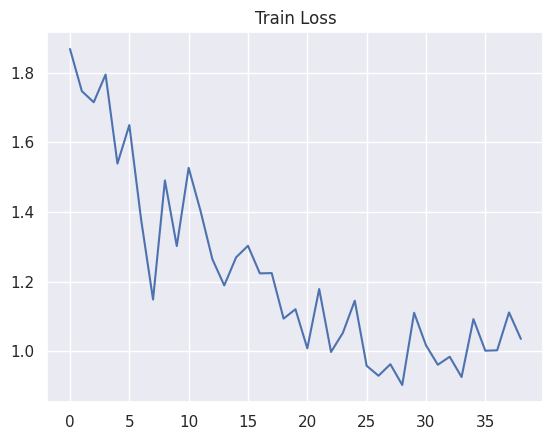

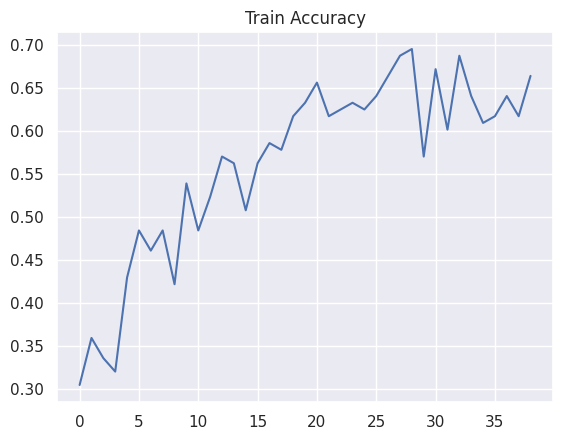

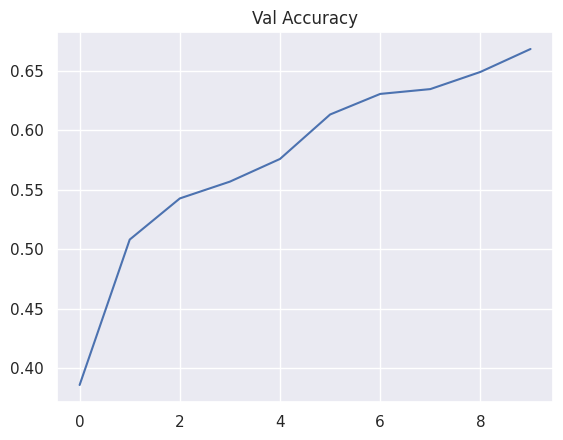

In [15]:
# Initilize model (ClassificationViT)
model = ClassificationViT(10)
# Move model to GPU 
model.to(torch_device)
# Create optimizer for the model

# You may want to tune these hyperparameters to get better performance
optimizer = optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.95), weight_decay=1e-9)

total_steps = 0
num_epochs = 10
train_logfreq = 100
losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x, y = x.to(torch_device), y.to(torch_device)
        logits = model(x)
        loss = torch.mean(F.cross_entropy(logits, y))
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item(), train_acc=accuracy.item())

        if total_steps % train_logfreq == 0:
            losses.append(loss.item())
            train_acc.append(accuracy.item())

    # Validation
    val_acc = []
    model.eval()
    for x, y in testloader:
        x, y = x.to(torch_device), y.to(torch_device)
        with torch.no_grad():
          logits = model(x)
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        val_acc.append(accuracy.item())
    model.train()

    all_val_acc.append(np.mean(val_acc))
    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

plt.plot(losses)
plt.title('Train Loss')
plt.figure()
plt.plot(train_acc)
plt.title('Train Accuracy')
plt.figure()
plt.plot(all_val_acc)
plt.title('Val Accuracy')

In [23]:
#@title Test your implementation
auto_grader_data['output']['vit_acc'] = best_val_acc
save_auto_grader_data()
check_acc(best_val_acc, threshold=0.65)

The accuracy 0.6683148734177216 is better than threshold accuracy 0.65


## Masked AutoEncoder

The second part of this notebook is implementing Masked Autoencoder (MAE).
The idea of MAE is masking random patches of the input image and reconstruct the missing pixels. This whole achitecture can be seen in the following figure.
![mae](https://user-images.githubusercontent.com/11435359/146857310-f258c86c-fde6-48e8-9cee-badd2b21bd2c.png)

You will train MAE without labels on CIFAR, aka, self-supervised learning.
Then you will use the self-supervised pretrained model for linear classification and finetuning experiments.

### Random Masking and Restore

**Implement ```random_masking``` to mask random patches from the input image and ```restore_masked``` to combine reconstructed masked part and unmasked part to restore the image.**

The `index_sequence` utility function has been provided to you, along with two examples:

In [24]:
def index_sequence(x, ids):
    """Index tensor (x) with indices given by ids
    Args:
        x: input sequence tensor, can be 2D (batch x length) or 3D (batch x length x feature)
        ids: 2D indices (batch x length) for re-indexing the sequence tensor
    """
    if len(x.shape) == 3:
        ids = ids.unsqueeze(-1).expand(-1, -1, x.shape[-1])
    return torch.take_along_dim(x, ids, dim=1)

In [25]:
print(index_sequence(
    torch.tensor([
        [0.0, 0.1, 0.2],
        [1.0, 1.1, 1.2]
    ], dtype=torch.float),
    torch.tensor([
        [0, 2],
        [0, 1]
    ], dtype=torch.long)
))

tensor([[0.0000, 0.2000],
        [1.0000, 1.1000]])


In [26]:
print(index_sequence(
    torch.tensor([
        [[0.01, 0.02], [0.11, 0.12], [0.21, 0.22]],
        [[1.01, 1.02], [1.11, 1.12], [1.21, 1.22]]
    ], dtype=torch.float),
    torch.tensor([
        [0, 2],
        [0, 1]
    ], dtype=torch.long)
))

tensor([[[0.0100, 0.0200],
         [0.2100, 0.2200]],

        [[1.0100, 1.0200],
         [1.1100, 1.1200]]])


In [27]:
def random_masking(x, keep_length, ids_shuffle):
    """Apply random masking on input tensor
    Args:
        x: input patches (batch x length x feature)
        keep_length: length of unmasked patches
        ids_shuffle: random indices for shuffling the input sequence. This is an
            array of size (batch x length) where each row is a permutation of 
            [0, 1, ..., length-1]. We will pass this array to index_sequence function
            to chooose the unmasked patches.
        
    Returns:
        kept: unmasked part of x: (batch x keep_length x feature)
        mask: a 2D (batch x length) mask tensor of 0s and 1s indicated which
            part of x is masked out. The value 0 indicates not masked and 1
            indicates masked.
        ids_restore: indices to restore x. This is an array of size (batch x length).
            If we take the kept part and masked
            part of x, concatentate them together and index it with ids_restore,
            we should get x back. (Hint: try using torch.argsort on the shuffle indices)
    """
    ############################################################################
    # TODO: implement this function
    ############################################################################
    batch, length, dim = x.shape
    ids_restore = torch.argsort(ids_shuffle, dim=1)
    kept = index_sequence(x, ids_shuffle[:, :keep_length])
    mask = x.new_ones([batch, length])
    mask[:, :keep_length] = 0.0
    mask = index_sequence(mask, ids_restore)
    return kept, mask, ids_restore
    ############################################################################

def restore_masked(kept_x, masked_x, ids_restore):
    """Restore masked patches
    Args:
        kept_x: unmasked patches: (batch x keep_length x feature)
        masked_x: masked patches: (batch x (length - keep_length) x feature)
        ids_restore: indices to restore x: (batch x length)
    Returns:
        restored patches
    Hint: use index_sequence function on an array with the kept and masked tokens concatenated
    """
    ############################################################################
    # TODO: implement this function
    ############################################################################
    return index_sequence(torch.cat([kept_x, masked_x], dim=1), ids_restore)
    ############################################################################

In [28]:
#@title Test your implementation
x, ids_shuffle = test_data['input']['random_masking']
kept, mask, ids_restore = random_masking(x, 4, ids_shuffle)
kept_t, mask_t, ids_restore_t = test_data['output']['random_masking']
check_error('random_masking: kept', kept, kept_t)
check_error('random_masking: mask', mask, mask_t)
check_error('random_masking: ids_restore', ids_restore, ids_restore_t)

x, ids_shuffle = auto_grader_data['input']['random_masking']
kept, mask, ids_restore = random_masking(x, 4, ids_shuffle)
auto_grader_data['output']['random_masking'] = (kept, mask, ids_restore)
save_auto_grader_data()

kept_x, masked_x, ids_restore = test_data['input']['restore_masked']
restored = restore_masked(kept_x, masked_x, ids_restore)
check_error('restore_masked', restored, test_data['output']['restore_masked'])

kept_x, masked_x, ids_restore = auto_grader_data['input']['restore_masked']
restored = restore_masked(kept_x, masked_x, ids_restore)
auto_grader_data['output']['restore_masked'] = (kept, mask, ids_restore)
save_auto_grader_data()

The relative error for random_masking: kept is 0.0
The relative error for random_masking: mask is 0.0
The relative error for random_masking: ids_restore is 0.0
The relative error for restore_masked is 0.0


### Masked Autoencoder

**Implement the following methods of `MaskedAutoEncoder`**:

- `forward_encoder`: Encodes the input images. It involves patchifying images into patches, randomly masking some patches, and encode the masked image with the ViT encoder. The mask information should also be returned, which will then be passed to the `forward` method.

- `forward_decoder`: Decodes the encoder embeddings. It involves restoring the sequence from masked patches and encoder predictions using ViT decoder, and projecting to predict image patches.

- `forward_encoder_representation`: Encodes images without applying random masking to get a representation of the input images.

In [29]:
class MaskedAutoEncoder(nn.Module):
    """MAE Encoder
    Args:
        encoder: vit encoder
        decoder: vit decoder
        encoder_embedding_dim: embedding size of encoder
        decoder_embedding_dim: embedding size of decoder
        patch_size: image patch size
        num_patches: number of patches
        mask_ratio: percentage of masked patches
    """
    def __init__(self, encoder, decoder, encoder_embedding_dim=256, 
                 decoder_embedding_dim=128, patch_size=4, num_patches=8,
                 mask_ratio=0.75):
        super().__init__()
        self.encoder_embedding_dim = encoder_embedding_dim
        self.decoder_embedding_dim = decoder_embedding_dim
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.mask_ratio = mask_ratio

        self.masked_length = int(num_patches * num_patches * mask_ratio)
        self.keep_length = num_patches * num_patches - self.masked_length

        self.encoder = encoder
        self.decoder = decoder

        self.encoder_input_projection = nn.Linear(patch_size * patch_size * 3, encoder_embedding_dim)
        self.decoder_input_projection = nn.Linear(encoder_embedding_dim, decoder_embedding_dim)
        self.decoder_output_projection = nn.Linear(decoder_embedding_dim, patch_size * patch_size * 3)
        self.cls_token = nn.Parameter(torch.randn(1, 1, encoder_embedding_dim) * 0.02)
        self.encoder_position_encoding = nn.Parameter(torch.randn(1, num_patches * num_patches, encoder_embedding_dim) * 0.02)
        self.decoder_position_encoding = nn.Parameter(torch.randn(1, num_patches * num_patches, decoder_embedding_dim) * 0.02)
        self.masked_tokens = nn.Parameter(torch.randn(1, 1, decoder_embedding_dim) * 0.02)

    def forward_encoder(self, images, ids_shuffle=None):
        """
        Encode input images using the following steps:

        1. Divide the images into smaller patches using the `patchify` function.
        2. Apply a linear projection to each image patch.
        3. Add position encoding to the projected patches.
        4. Mask out a subset of patches using the `random_masking` function.
           - Note that `ids_shuffle` is optional. If it is omitted, you need to 
             generate a random permutation of patch indices and pass it to the
             `random_masking` function
        5. Concatenate the CLS token embedding with the masked patch embeddings.
           - The embedding of the CLS token is defined as `self.cls_token`
        6. Pass the combined tensor to the ViT encoder and return its output,
           along with the mask and the ids_restore tensor obtained in step 4.
        """
        ########################################################################
        # TODO: implement this function
        ########################################################################
        batch_size = images.shape[0]
        if ids_shuffle is None:
            ids_shuffle = torch.argsort(
                torch.rand(
                    (batch_size, self.num_patches * self.num_patches),
                    device=images.device
                ),
                dim=1
            )

        patches = patchify(images, self.patch_size)
        patch_embeddings = self.encoder_input_projection(patches) + self.encoder_position_encoding
        kept, mask, ids_restore = random_masking(patch_embeddings, self.keep_length, ids_shuffle)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        embeddings = torch.cat([cls_token, kept], dim=1)
        return self.encoder(embeddings), mask, ids_restore
        ########################################################################

    def forward_decoder(self, encoder_embeddings, ids_restore):
        """
        Decode encoder embeddings using the following steps:

        1. Apply a linear projection to the encoder output.
        2. Extract the CLS token from the projected decoder embeddings and set
           it aside.
        3. Restore the sequence by inserting MASK tokens into the decoder
           embeddings, while also removing the CLS token from the sequence.
           - The embedding of the MASK token is defined as `self.masked_tokens`
        4. Add position encoding to the restored decoder embeddings.
        5. Re-concatenate the CLS token with the decoder embeddings.
        6. Pass the combined tensor to the ViT decoder, and retrieve the decoder
           output by excluding the CLS token.
        7. Apply the decoder output projection to the decoder output to predict
           image patches, and return the result.
        """
        ########################################################################
        # TODO: implement this function
        ########################################################################
        batch_size = encoder_embeddings.shape[0]
        decoder_embeddings = self.decoder_input_projection(encoder_embeddings)
        cls_token = decoder_embeddings[:, :1, :]
        decoder_embeddings = decoder_embeddings[:, 1:, :]
        masked_patches = self.masked_tokens.expand(batch_size, self.masked_length, -1)
        decoder_embeddings = restore_masked(decoder_embeddings, masked_patches, ids_restore)
        decoder_embeddings = decoder_embeddings + self.decoder_position_encoding
        decoder_embeddings = torch.cat([cls_token, decoder_embeddings], dim=1)
        decoder_output = self.decoder(decoder_embeddings)[:, 1:, :]
        output = self.decoder_output_projection(decoder_output)
        return output
        ########################################################################

    def forward(self, images):
        encoder_output, mask, ids_restore = self.forward_encoder(images)
        decoder_output = self.forward_decoder(encoder_output, ids_restore)
        return decoder_output, mask

    def forward_encoder_representation(self, images):
        """
        Encode input images **without** applying random masking, following step
        1, 2, 3, 5, 6 of `forward_encoder`
        """
        ########################################################################
        # TODO: implement this function
        ########################################################################
        batch_size = images.shape[0]
        patches = patchify(images, self.patch_size)
        patch_embeddings = self.encoder_input_projection(patches)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        embeddings = patch_embeddings + self.encoder_position_encoding
        embeddings = torch.cat([cls_token, embeddings], dim=1)
        return self.encoder(embeddings)
        ########################################################################

In [30]:
#@title Test your implementation
model = MaskedAutoEncoder(
    Transformer(embedding_dim=256, n_layers=4),
    Transformer(embedding_dim=128, n_layers=2),
)

model.load_state_dict(test_data['weights']['MaskedAutoEncoder'])
images, ids_shuffle = test_data['input']['MaskedAutoEncoder.forward_encoder']
encoder_embeddings_t, mask_t, ids_restore_t = test_data['output']['MaskedAutoEncoder.forward_encoder']
encoder_embeddings, mask, ids_restore = model.forward_encoder(
    images, ids_shuffle
)

check_error(
    'MaskedAutoEncoder.forward_encoder: encoder_embeddings',
    encoder_embeddings, encoder_embeddings_t, .008
)
check_error(
    'MaskedAutoEncoder.forward_encoder: mask',
    mask, mask_t
)
check_error(
    'MaskedAutoEncoder.forward_encoder: ids_restore',
    ids_restore, ids_restore_t
)

encoder_embeddings, ids_restore = test_data['input']['MaskedAutoEncoder.forward_decoder']
decoder_output_t = test_data['output']['MaskedAutoEncoder.forward_decoder']
decoder_output = model.forward_decoder(encoder_embeddings, ids_restore)
check_error(
    'MaskedAutoEncoder.forward_decoder',
    decoder_output,
    decoder_output_t, .03
)

images = test_data['input']['MaskedAutoEncoder.forward_encoder_representation']
encoder_representations_t = test_data['output']['MaskedAutoEncoder.forward_encoder_representation']
encoder_representations = model.forward_encoder_representation(images)
check_error(
    'MaskedAutoEncoder.forward_encoder_representation',
    encoder_representations,
    encoder_representations_t, .01
)



model = MaskedAutoEncoder(
    Transformer(embedding_dim=256, n_layers=4),
    Transformer(embedding_dim=128, n_layers=2),
)

model.load_state_dict(auto_grader_data['weights']['MaskedAutoEncoder'])
images, ids_shuffle = auto_grader_data['input']['MaskedAutoEncoder.forward_encoder']
auto_grader_data['output']['MaskedAutoEncoder.forward_encoder'] = model.forward_encoder(
    images, ids_shuffle
)

encoder_embeddings, ids_restore = auto_grader_data['input']['MaskedAutoEncoder.forward_decoder']
auto_grader_data['output']['MaskedAutoEncoder.forward_decoder'] = model.forward_decoder(encoder_embeddings, ids_restore)

images = auto_grader_data['input']['MaskedAutoEncoder.forward_encoder_representation']
auto_grader_data['output']['MaskedAutoEncoder.forward_encoder_representation'] = model.forward_encoder_representation(images)
save_auto_grader_data()


The relative error for MaskedAutoEncoder.forward_encoder: encoder_embeddings is 0.007438282482326031
The relative error for MaskedAutoEncoder.forward_encoder: mask is 0.0
The relative error for MaskedAutoEncoder.forward_encoder: ids_restore is 0.0
The relative error for MaskedAutoEncoder.forward_decoder is 0.013390465639531612
The relative error for MaskedAutoEncoder.forward_encoder_representation is 0.0067453403025865555


### Train Masked Autoencoder

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Text(0.5, 1.0, 'MAE Train Loss')

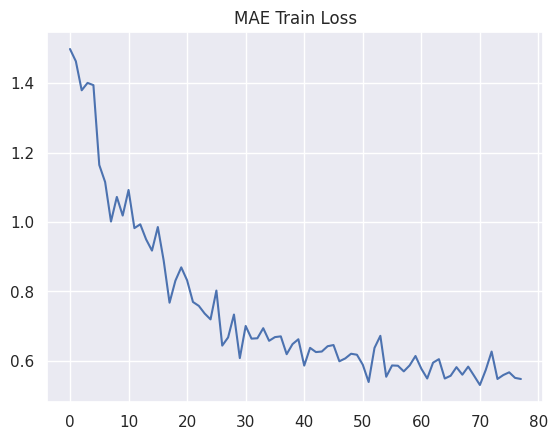

In [31]:
# Initilize MAE model
model = MaskedAutoEncoder(
    Transformer(embedding_dim=256, n_layers=4),
    Transformer(embedding_dim=128, n_layers=2),
)
# Move the model to GPU
model.to(torch_device)
# Create optimizer

# You may want to tune these hyperparameters to get better performance
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95), weight_decay=0.05)

total_steps = 0
num_epochs = 20
train_logfreq = 100

losses = []

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x = x.to(torch_device)
        image_patches = patchify(x)
        predicted_patches, mask = model(x)
        loss = torch.sum(torch.mean(torch.square(image_patches - predicted_patches), dim=-1) * mask) / mask.sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item())
        if total_steps % train_logfreq == 0:
            losses.append(loss.item())

    # Periodically save model
    torch.save(model.state_dict(), os.path.join(root_folder, "mae_pretrained.pt"))

plt.plot(losses)
plt.title('MAE Train Loss')

### Use pretrained MAE model for classification

As ViT has a class token, to adapt to this design, in our MAE pre-training we append an auxiliary dummy token to the encoder input. This token will be treated as the class token for training the classifier in linear probing and fine-tuning.

The `ClassificationMAE` class wraps your pretrained MAE and leverage the CLS token for classification. **Implement the `forward` method of `ClassificationMAE`.** It should support two modes controlled by the `detach` flag:

- Linear probe mode (`detach` is true): the backpropagation does not run through the pretrained MAE backbone, and only the output classification layer is updated during training.

- Full finetuning mode (`detach` is false): the MAE backbone as well as the classification layer is updated during training.

In [32]:
class ClassificationMAE(nn.Module):
    """A linear classifier is trained on self-supervised representations learned by MAE. 
    Args:
        n_classes: number of classes
        mae: mae model
        embedding_dim: embedding dimension of mae output
        detach: if True, only the classification head is updated.
    """
    def __init__(self, n_classes, mae, embedding_dim=256, detach=False):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.mae = mae
        self.output_head = nn.Sequential(
            nn.LayerNorm(embedding_dim), nn.Linear(embedding_dim, n_classes)
        )
        self.detach = detach

    def forward(self, images):
        """
        Args:
            Images: batch of images
        Returns:
            logits: batch of logits from the ouput_head
        Remember to detach the representations if self.detach=True, and 
        Remember that we do not use masking here.
        """
        ########################################################################
        # TODO: implement this function
        ########################################################################
        mae_embeddings = self.mae.forward_encoder_representation(images)
        if self.detach:
            mae_embeddings = mae_embeddings.detach()
        return self.output_head(mae_embeddings[:, 0, :])
        ########################################################################

In [33]:
#@title Test your implementation
model = ClassificationMAE(
    10,
    MaskedAutoEncoder(
        Transformer(embedding_dim=256, n_layers=4),
        Transformer(embedding_dim=128, n_layers=2),
    )
)

model.load_state_dict(test_data['weights']['ClassificationMAE'])

check_error(
    'ClassificationMAE.forward',
    model(test_data['input']['ClassificationMAE.forward']),
    test_data['output']['ClassificationMAE.forward']
)

model = ClassificationMAE(
    10,
    MaskedAutoEncoder(
        Transformer(embedding_dim=256, n_layers=4),
        Transformer(embedding_dim=128, n_layers=2),
    )
)

model.load_state_dict(auto_grader_data['weights']['ClassificationMAE'])
auto_grader_data['output']['ClassificationMAE.forward'] = model(
    auto_grader_data['input']['ClassificationMAE.forward']
)
save_auto_grader_data()

The relative error for ClassificationMAE.forward is 7.202581036835909e-05


### Load the pretrained MAE model

In [34]:
mae = MaskedAutoEncoder(
    Transformer(embedding_dim=256, n_layers=4),
    Transformer(embedding_dim=128, n_layers=2),
)
mae.load_state_dict(torch.load(os.path.join(root_folder, "mae_pretrained.pt")))

<All keys matched successfully>

### Linear Classification

A linear classifier is trained on self-supervised representations learned by MAE. 

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Linear Classification Val Accuracy')

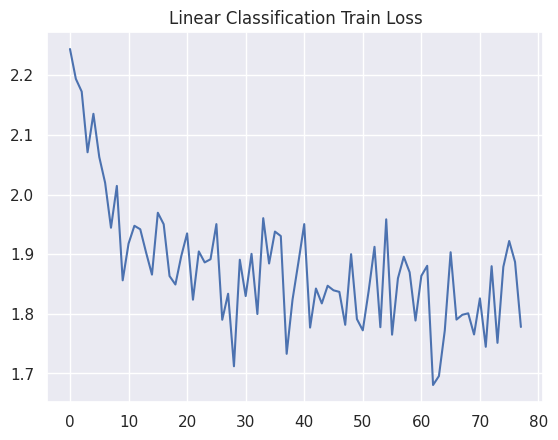

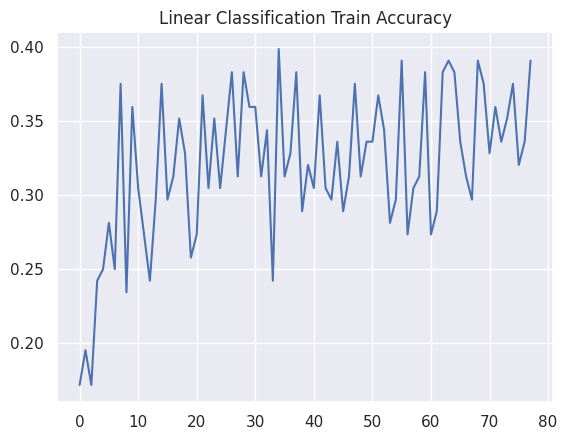

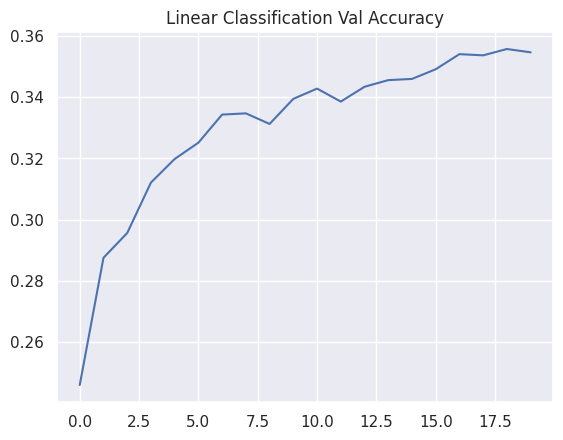

In [35]:
# Initilize classification model; set detach=True to only update the linear classifier. 
model = ClassificationMAE(10, mae, detach=True)
model.to(torch_device)

# You may want to tune these hyperparameters to get better performance
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95), weight_decay=1e-9)

total_steps = 0
num_epochs = 20
train_logfreq = 100
losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x, y = x.to(torch_device), y.to(torch_device)
        logits = model(x)
        loss = torch.mean(F.cross_entropy(logits, y))
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item(), train_acc=accuracy.item())

        if total_steps % train_logfreq == 0:
            losses.append(loss.item())
            train_acc.append(accuracy.item())

    # Validation
    val_acc = []
    model.eval()
    for x, y in testloader:
        x, y = x.to(torch_device), y.to(torch_device)
        with torch.no_grad():
          logits = model(x)
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        val_acc.append(accuracy.item())

    model.train()

    all_val_acc.append(np.mean(val_acc))

    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

plt.plot(losses)
plt.title('Linear Classification Train Loss')
plt.figure()
plt.plot(train_acc)
plt.title('Linear Classification Train Accuracy')
plt.figure()
plt.plot(all_val_acc)
plt.title('Linear Classification Val Accuracy')

In [36]:
#@title Test your implementation
auto_grader_data['output']['mae_linear_acc'] = best_val_acc
save_auto_grader_data()
check_acc(best_val_acc, threshold=0.30)

The accuracy 0.3558148734177215 is better than threshold accuracy 0.3


### Full Finetuning

A linear classifer and the pretrained MAE model are jointly updated.

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Finetune Classification Val Accuracy')

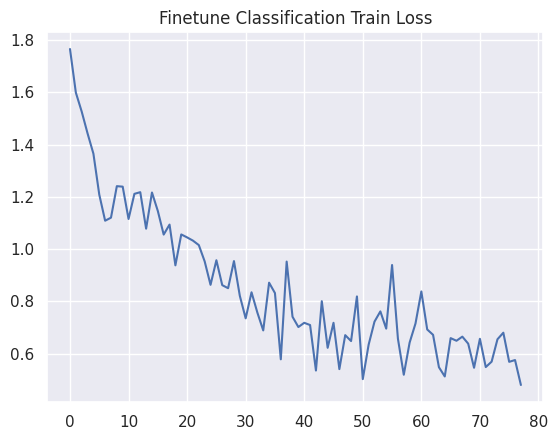

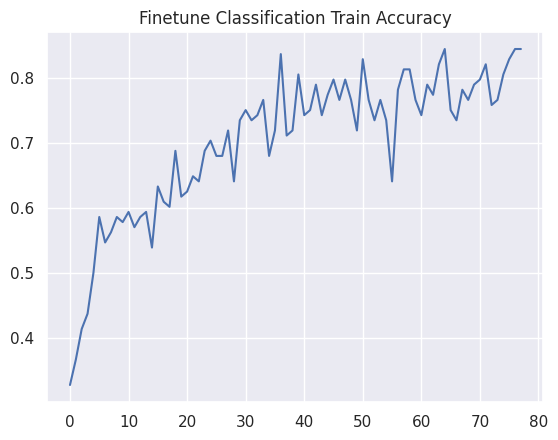

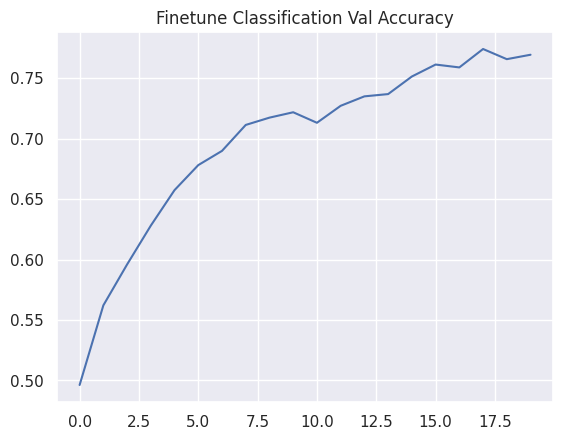

In [37]:
# Initilize classification model; set detach=False to update both the linear classifier and pretrained MAE model.
model = ClassificationMAE(10, mae, detach=False)
model.to(torch_device)

# You may want to tune these hyperparameters to get better performance
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95), weight_decay=1e-9)

total_steps = 0
num_epochs = 20
train_logfreq = 100
losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x, y = x.to(torch_device), y.to(torch_device)
        logits = model(x)
        loss = torch.mean(F.cross_entropy(logits, y))
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item(), train_acc=accuracy.item())

        if total_steps % train_logfreq == 0:
            losses.append(loss.item())
            train_acc.append(accuracy.item())

    # Validation
    val_acc = []
    model.eval()
    for x, y in testloader:
        x, y = x.to(torch_device), y.to(torch_device)
        with torch.no_grad():
          logits = model(x)
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        val_acc.append(accuracy.item())
    model.train()

    all_val_acc.append(np.mean(val_acc))

    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

plt.plot(losses)
plt.title('Finetune Classification Train Loss')
plt.figure()
plt.plot(train_acc)
plt.title('Finetune Classification Train Accuracy')
plt.figure()
plt.plot(all_val_acc)
plt.title('Finetune Classification Val Accuracy')

In [39]:
#@title Test your implementation
auto_grader_data['output']['mae_finetune_acc'] = best_val_acc
save_auto_grader_data()
check_acc(best_val_acc, threshold=0.70)

The accuracy 0.774129746835443 is better than threshold accuracy 0.7


## Prepare Gradescope submission

**NOTE:** change the following path to your ```root_dir``` in the begining.

Run the following cell will automatically prepare and download ```hw9_submission.zip```.

Upload the downloaded file to Gradescope.
The Gradescope will run an autograder on the files you submit. 

It is very unlikely but still possible that your implementation might fail to pass some test cases due to randomness.
If you think your code is correct, you can simply rerun the autograder to check check whether it is really due to randomness.

In [57]:

!pwd # make sure we are in the right dir

!rm hw9_submission.zip
!zip hw9_submission.zip /kaggle/working -r *.ipynb /content/drive/MyDrive/cs182_hw9_mae/autograder.pt

from google.colab import files
files.download('hw9_submission.zip') 

/kaggle/working
  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/__notebook_source__.ipynb (deflated 44%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: __notebook_source__.ipynb (deflated 44%)
  adding: content/drive/MyDrive/cs182_hw9_mae/autograder.pt (deflated 8%)


ModuleNotFoundError: No module named 'google.colab'

In [44]:
!pwd

/content/drive/MyDrive/cs182_hw9_mae


In [48]:
!cd /kaggle/working

In [49]:
f = open("demofile2.txt", "a")
f.write("Now the file has more content!")
f.close()

In [51]:
colab_root_folder

'/content/drive/MyDrive/cs182_hw9_mae'

In [52]:
root_folder

'/content/drive/MyDrive/cs182_hw9_mae'

In [55]:
os.getcwd()

'/kaggle/working'

In [54]:
os.chdir(r'/kaggle/working')